# Настройки обучения нейронных сетей в `PyTorch`

<!-- [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1k5ih-FSbCTuErwBHHi3J3uCN1q4fRzFI) -->

Как правило, обучение моделей в `PyTorch` — это продолжительный процесс, который требует достаточно много усилий. Эти усилия на этапе аналитики сосредотачиваются на подготовке данных и экспериментировании с моделью нейронной сети и ее обучением.

Как будет показано позже, часто среди моделей машинного обучения выбираются готовые модели, которые используются как некоторая основа. Часто эти модели предобучены. Однако качество предобученной модели на целевом наборе данных, как правило, неудовлетворительное. Поэтому модели в любом случае надо доучивать.

Ниже приведен [один из примеров последовательности](https://www.learnpytorch.io/01_pytorch_workflow/#what-were-going-to-cover), которая соответствует общему порядку экспериментов с нейронной сетью.  Текущая практика посвящена вопросу обучения нейронной сети во многих аспектах этого `workflow`.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01_a_pytorch_workflow.png" width="900px">

Важно:
* также иметь в виду вопросы ускорения и вычислительной оптимизации обучения нейронных сетей, см., например, [тут](https://habr.com/ru/companies/wunderfund/articles/820721/) и для [`CPU` тут](https://habr.com/ru/companies/ruvds/articles/822711/). 
* И учитывать вопросы логирования результатов экспериментов, см., например, [тут](https://www.learnpytorch.io/07_pytorch_experiment_tracking/).
* Этапы не включают постановку задачи, выбор метрик, гипотезу о baseline
* В некоторой степени представленный workflow соответствует концепции [`OSEMN`](https://www.datascience-pm.com/osemn/).
<img src='https://thelead.io/wp-content/uploads/2018/12/Data-Science_OSEMN-Framework.png' width='800px'>

## Импорт `torch`

In [1]:
import random
import os
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

In [3]:
import torchvision
from torchvision import transforms, datasets
import torchvision.transforms as T

In [5]:
from torchinfo import summary
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from tqdm.notebook import tqdm, trange

Настроим работу с `PyTorch`. Выберем формат работы и устройство для работы.

In [6]:
def torch_stats(): 
    torch_version = ".".join(torch.__version__.split(".")[:2])
    print('torch version:',torch_version)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    dtype = torch.float32
    
    if device.type == 'cuda':
        cuda_version  = torch.__version__.split("+")[-1]
        print("cuda: ", cuda_version)
        
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        print('Cuda is available:',torch.cuda.is_available())

        n_devices = torch.cuda.device_count()
        print('number of devices: %d'%(n_devices))

        for cnt_device in range(n_devices):
            print(torch.cuda.get_device_name(cnt_device))
            print('Memory Usage:')
            print('Allocated:', round(torch.cuda.memory_allocated(cnt_device)/1024**3,1), 'GB')
            print('Cached:   ', round(torch.cuda.memory_reserved(cnt_device)/1024**3,1), 'GB')


    torch.set_default_dtype(dtype) # float32
    print('default data type:',dtype)
    
    num_workers=os.cpu_count()
    print ('available number of workers:',num_workers)
    
    return device, dtype, num_workers
#-------------------------------
def torch_seed(seed = 42, deterministic = True):
    random.seed(seed) # random and transforms
    np.random.seed(seed) #numpy
    torch.manual_seed(seed) #cpu
    torch.cuda.manual_seed(seed) #gpu
    torch.backends.cudnn.deterministic=deterministic #cudnn 
    torch.backends.cudnn.benchmark = False

In [7]:
device, dtype, num_workers = torch_stats()
torch_seed(seed = 42, deterministic = True)

torch version: 2.2
Using device: cpu
default data type: torch.float32
available number of workers: 8


## Набор данных

### Загрузка преобразований данных `test_data.classes`

Рассмотрим набор данных [`FashionMNIST`](https://pytorch.org/vision/0.18/generated/torchvision.datasets.FashionMNIST.html), который в этот раз импортируется из пакета `torchvision.datasets`.

При загрузке набора данных задаются стандартные преобразования `transforms`.

* Минимальное преобразование, которое необходимо произвести, — это преобразовать входные данные в тензор. 
* В нашем случае мы также проведем преобразование входного изображения в вектор. Изображения в наборе данных имеют размер $28\times 28$, это значит, что в результате преобразований будет тензор, имеющий $28\cdot 28 = 784$ значения. 
* Также проведем нормализацию входного тензора в диапазон $[0, 1]$. Мы знаем, что входные данные представляют собой бинарное изображение, где максимальное значение — `255`, а минимальное — `0`. Поэтому нормировку мы проведем при помощи деления на `255`.
* `PyTorch` позволяет производить преобразования входных данных при помощи класса `transforms.Compose`. Объект этого класса позволяет описывать последовательность преобразований над входными данными, указывая их в виде списка.

Объект `transform` класса `transforms.Compose` будет передан в соответствующем аргументе в загрузчик данных нашего датасета.


In [48]:
transform_ = lambda x: x.flatten() / 255.0
transform=transforms.Compose([
                           transforms.ToTensor(),
                           transform_,
                            ])

### Загрузка набора данных из модуля `datasets`

 Тренировочная часть и тестовая часть загружаются отдельно.

In [49]:
# import ssl
# ssl._create_default_https_context = ssl._create_stdlib_context

In [53]:
train_data = datasets.MNIST('data', train=True,  download=True, transform=None)
test_data  = datasets.MNIST('data', train=False, download=True, transform=None)

In [54]:
transforms.ToTensor()(train_data[0][0]).shape

torch.Size([1, 28, 28])

In [55]:
np.array(train_data[0][0]).shape

(28, 28)

In [56]:
train_data = datasets.MNIST('data', train=True,  download=True, transform=transform)
test_data  = datasets.MNIST('data', train=False, download=True, transform=transform)

In [57]:
test_data.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

Полученный набор данных представляет собой итерируемый объект. 

Доступ к отдельным элементам такого датасета может быть получен как для списка. 

Каждый элемент представляет собой изображение (в нашем случае — вектор) и его метку.

In [58]:
train_data[0][0].shape, train_data[0][1] 

(torch.Size([784]), 5)

Зададимся именами классов.

In [59]:
name_classes = test_data.classes
#['T-Shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']

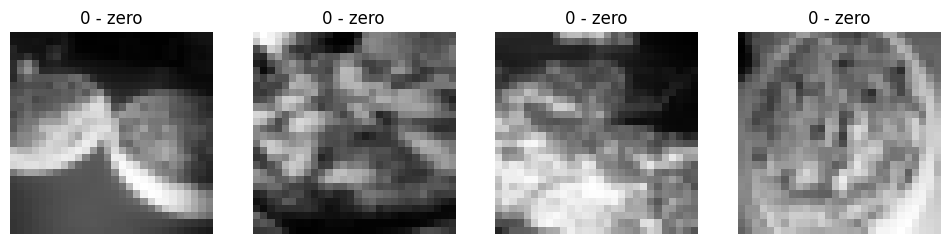

In [83]:
WIDTH = 28
HEIGH = 28

n_imgs = 4

fig, axs = plt.subplots(1,n_imgs,figsize=(12,3));
for i,ax in enumerate(axs):
    im = train_data[i]
    ax.imshow(im[0].view(WIDTH,HEIGH), cmap='gray'); 
    ax.set_title(name_classes[im[1]]); 
    ax.axis('off')
plt.show()

Соотвественно можно узнать размер выборок

In [61]:
len(train_data), len(test_data)

(60000, 10000)

### Выбор валидационной подвыборки

Набор данных имеет только тренировочную часть и тестовую часть. Однако нам также понадобиться валидационная часть, которую можно выделить из тренировочной. 
 
Для выделения валидационного набора используем утилиту `random_split` из `torch.utils.data`. 

<blockquote> 
Отметим, что могут быть и другие способы сплита данных.
    
<details>    
    
```python
    from torch.utils.data import SubsetRandomSampler
    indices=np.arange(len(train))
    np.random.shuffle(indices)
    
    split=int(np.floor(valid_size*len(train)))
    train_idx = indices[split:]
    valid_idx = indices[:split]
    
    train_sampler=SubsetRandomSampler(train_idx)
    valid_sampler=SubsetRandomSampler(valid_idx)
    
    
    train_loader=torch.utils.data.DataLoader(train_data, batch_size=batch_size,  
                                             sampler=train_sampler, num_workers=num_workers)
    valid_loader=torch.utils.data.DataLoader(train_data, batch_size=batch_size,  
                                             sampler=train_sampler, shuffle=False, num_workers=num_workers)
    test_loader =torch.utils.data.DataLoader(test_data,  batch_size=batch_size, 
                                             shuffle=False,  num_workers=num_workers)

```

</blockquote>

In [66]:

TRAIN_RATIO = 0.7

g = torch.Generator(device = device)

n_train_examples = int(len(train_data) * TRAIN_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = torch.utils.data.random_split(train_data, [n_train_examples, n_valid_examples], generator = g)

print(f"Training data size : {len(train_data)},\
        Validation data size : {len(valid_data)},\
        Test data size : {len(test_data)}")

Training data size : 20579,        Validation data size : 8820,        Test data size : 10000


Теперь получены три набора данных: валидационный, тренировочный и тестовый. <br>
__Важно__ также отметить, что если тренировочные данные используются с аугментацией, то валидационный набор данных лучше использовать без аугментации. Ниже показан пример того как это можно сделать.

```python
    valid_data = copy.deepcopy(valid_data)
    valid_data.dataset.transform = test_transforms
```




In [25]:
import copy
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = transforms

## Загрузчик пакетов данных

После загрузки изображений в формате `pytorch` необходимо автоматизировать генерацию минибатчей, по которым будет производиться обучение. 

Желательно производить загрузку батчей динамически/стохастически. Другими словами, во время каждой эпохи обучения мы будем вызывать необходимое количество таких батчей, каждый из которых будет представлять собой заданное количество примеров входных данных, выбранных случайно из последовательности.

Для осуществления указанного кода воспользуемся утилитой `DataLoader` из `torch.utils.data`. Пример реализации показан ниже.

In [67]:
BATCH_SIZE = 64
g = torch.Generator(device = device)

train_loader = data.DataLoader(train_data,
                                 shuffle=True,
                                 generator = g,  
                                 batch_size=BATCH_SIZE)

val_loader = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_loader = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

 
print(f"Training data batches : {len(train_loader)},\
        Validation data batches : {len(val_loader)},\
        Test data batches : {len(test_loader)}")

Training data batches : 322,        Validation data batches : 138,        Test data batches : 157


Проверим размер каждого батча.

In [68]:
images, _ =  next(iter(train_loader))
images.shape

torch.Size([64, 784])

Проведем визуализацию батча. Для этого в `torchvision` предусмотрена специальная функция `make_grid`.
<!-- 
Обратите внимание на порядок операций в примере с визуализацией. Сначала производится преобразование размеров батча. Из размеров $[64, 784]$, означающих $64$ вектора, каждый по $784$ значения, мы получаем 64 изображения, каждое размером $28\times 28$.\
Однако также мы добавляем дополнительную пустую размерность. То есть вместо того, чтобы получить массив $[64, 28, 28]$, мы получаем размер $[64, 1, 28, 28]$. Дополнительная размерность означает канал изображения. В нашем случае канал только $1$. Однако в более продвинутых задачах анализа изображений мы будем использовать и по $3$ канала.\
Аналогично, и в нашем случае для визуализации батч будет создан с $3$ каналами. Поскольку мы формируем изображение, где по горизонтали должно уместиться 8 изображений, то размер будет $[3, 28\cdot 8, 28\cdot 8] = [3, 224, 224]$.

Также важно отметить, что после получения батча мы проводим операцию `transpose((1, 2, 0))` — то есть каналы становятся `3`-й размерностью, а не `1`-й. Тут имеет место крайне важное различие между представлением данных в `matplotlib` и `torch`. В `matplotlib` каналы — это последняя размерность. Тогда как в `torch` каналы — это или `1`-я размерность, или `2`-я, если речь идет о наборе изображений (батче). -->

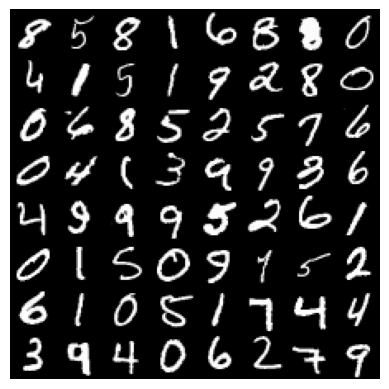

(torch.Size([64, 1, 28, 28]), torch.Size([3, 224, 224]), (224, 224, 3))

In [81]:
images = images.reshape(-1,1,28,28)
batch = torchvision.utils.make_grid(images, nrow = int(np.sqrt(images.shape[0])), padding = 0)
vis_batch = batch.data.numpy().transpose((1, 2, 0))*255
plt.imshow(vis_batch); 
plt.axis('off');
plt.show()
images.shape, batch.shape,  vis_batch.shape


## Задания

__1.__ Загрузите набор данных `MNIST` из `torchvision.datasetes`.

__2.__ Часто приходится скачивать свои набора данных для их загрузки в PyTorch. Одним из таких форматов являтется т.н. `ImageFolder`

Ниже показан пример загрузки набора данных `pizza_steak_sushi` из урока [`PyTorch Custom Datasets`](https://www.learnpytorch.io/04_pytorch_custom_datasets/). Первая часть примера позволяет загрузить данные из репозитория [pizza_steak_sushi](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip) который представляет собой подвыборку набора данных [Food101](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/).

In [74]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [75]:
train_dir = image_path / "train"
test_dir = image_path / "test"

data_transform = transforms.Compose([
    transforms.Resize(size=(28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transform_,])

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [76]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, transform=data_transform) 
test_data  = datasets.ImageFolder(root=test_dir, transform=data_transform)

print(f"Train data:{len(train_data)}\nTest data: {len(test_data)}")

Train data:225
Test data: 75


In [78]:
import os
os.listdir(os.path.join(os.getcwd(), 'data'))

['MNIST', 'pizza_steak_sushi.zip', 'FashionMNIST', 'pizza_steak_sushi']

In [80]:
os.listdir(os.path.join(os.getcwd(), 'data', 'pizza_steak_sushi', 'train'))

['steak', 'sushi', 'pizza']

__Предлагается__:
1. визуализировать данные из набора.
2. создать валидационную подвыборку. 
3. создать загрузчик батчей.

# Обучение полносвязной архитекутры

## Описание полносвязной сети

In [84]:
transform=transforms.Compose([
                           transforms.ToTensor(),
                           transform_,
                            ])
train_data = datasets.FashionMNIST('data', train=True,  download=True, transform=transform)
test_data  = datasets.FashionMNIST('data', train=False, download=True, transform=transform)
name_classes = test_data.classes
g = torch.Generator(device = device)

In [85]:
TRAIN_RATIO = 0.7

n_train_examples = int(len(train_data) * TRAIN_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = torch.utils.data.random_split(train_data, [n_train_examples, n_valid_examples], generator = g)

print(f"Training data size : {len(train_data)},\
        Validation data size : {len(valid_data)},\
        Test data size : {len(test_data)}")

Training data size : 42000,        Validation data size : 18000,        Test data size : 10000


In [86]:
BATCH_SIZE = 64

train_loader = data.DataLoader(train_data,
                                 shuffle=True,
                                 generator = g,  
                                 batch_size=BATCH_SIZE)

val_loader = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_loader = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

 
print(f"Training data batches : {len(train_loader)},\
        Validation data batches : {len(val_loader)},\
        Test data batches : {len(test_loader)}")

Training data batches : 657,        Validation data batches : 282,        Test data batches : 157


### Описание модели в классовом стиле

In [88]:
IMAGE_WIDTH = 28 
IMAGE_HEIGH = 28

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        # input(784)# We do not need this in the Pytorch
        self.fc1 = nn.Linear(IMAGE_WIDTH*IMAGE_HEIGH, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc_out = nn.Linear(32, 10)
        # self.act = nn.ReLU()

    def forward(self, batch):
        #batch = input(batch)# Auxiliary raw
        x1 = F.relu(self.fc1(batch))  # x1 = self.act( self.fc1(batch) )
        x2 = F.relu(self.fc2(x1))
        x_out = self.fc_out(x2)
        return x_out  #log(softmax(x)) in loss assumed

Также важно уточнить, что в указанных структурах могут быть заданы не только полные модели, но и их [отдельные слои](https://github.com/Devinterview-io/pytorch-interview-questions?tab=readme-ov-file#process-for-implementing-custom-layers).

Проверим результат.

In [92]:
model = Model()

summary(model,input_size =(1,784))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [1, 10]                   --
├─Linear: 1-1                            [1, 64]                   50,240
├─Linear: 1-2                            [1, 32]                   2,080
├─Linear: 1-3                            [1, 10]                   330
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.05
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.21
Estimated Total Size (MB): 0.21

В ручную посчитаем слой

In [95]:
784*64 + 64, (784*64 + 64)*4//1024

(50240, 196)

если размер входа 224, 224 и 3 канала (RGB)

In [97]:
224*224*3 * 64 + 64, (224*224*3 * 64 + 64)*4//1024

(9633856, 37632)

можем также посмотреть на именнованные параметры модели

In [110]:
for n,p in model.named_parameters():
    print(n,'\t',p.shape)

fc1.weight 	 torch.Size([64, 784])
fc1.bias 	 torch.Size([64])
fc2.weight 	 torch.Size([32, 64])
fc2.bias 	 torch.Size([32])
fc_out.weight 	 torch.Size([10, 32])
fc_out.bias 	 torch.Size([10])


### Выбор оптимизатора и функции потерь

Как и прежде, используем алгоритм `Adam` с параметрами по умолчанию для обновления нашей модели. Улучшенные результаты можно получить, перебирая различные оптимизаторы и скорости обучения, однако стандартный `Adam` обычно является хорошей отправной точкой. 

In [98]:
LR = 0.001
optimizer = optim.Adam(params = model.parameters(), lr = LR)

Аналогично предыдущим занятиям зададимся функцией потерь `CrossEntropyLoss`.

In [141]:
criterion = nn.CrossEntropyLoss() #This criterion assume built-in `log_softmax` combined with NLLLoss

Отметим, что на самом деле, если используется `GPU` в качестве вычислителя, то следует отправить и функцию потерь и модель на устройство.

In [142]:
model = model.to(device)
criterion = criterion.to(device)

Если для обучения моделей используют несколько `GPU`, то доступен параллелилизм

<details>

> Если для обучения моделей используют несколько GPU, то самым простым подходом в этой ситуации будет применение класса `DistributedDataParallel` (`DDP`). В результате будут созданы несколько идентичных процессов, а градиенты будут агрегироваться на шаге обратного прохода. <br>
> Также [может быть использован](https://habr.com/ru/companies/wunderfund/articles/820721/) `Fully Sharded Data Parallel` (`FSDP`, параллелизм с полным шардингом данных). В этом режиме данные асинхронно распределяются между `GPU` вместо того чтобы запускать код на каждом `GPU` с одинаковыми моделями и с одинаковыми состояниями оптимизатора.
> `from torch.distributed.fsdp import FullyShardedDataParallel as FSDP` и `model = FSDP(model)`
    
>Для более подробного исследования производительности модели рекомендуется использование профайлера https://pytorch.org/blog/introducing-pytorch-profiler-the-new-and-improved-performance-tool/.    

Также напомним, что в версии `PyTorch 2.x` доступен способ ускорения модели при помощи ее компиляции [`torch.compile`](https://pytorch.org/docs/stable/generated/torch.compile.html). [В этом режиме](https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html) вычислительный граф модели собирается при первом проходе по ней вместо того, чтобы вычисляться динамический каждый раз.

Отметим, что на сегодня `torch.compile` работает не на всех платформах.

In [111]:
from sys import platform
if platform == "linux" or platform == "linux2":
    model = torch.compile(model)

### Метрика 

Также создадим отдельную функцию для расчета точности модели.

In [112]:
def calculate_accuracy(y_pred, y):
    with torch.no_grad():
        top_pred = y_pred.argmax(1, keepdim=True)
        correct = top_pred.eq(y.view_as(top_pred)).sum()
        acc = correct.float() / y.shape[0]
    return acc

metric = calculate_accuracy

### Инициализация модели для ее тренирвоки

Объеденим предыдущие шаги вместе

In [115]:
LR = 0.001
model     = Model()
criterion = nn.CrossEntropyLoss()
model     = model.to(device)
criterion = criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr = LR)

metric = calculate_accuracy

## Функции для обучения и работы

### Функция тренировки `train`

Перед началом тренировки запишем функцию `train_epoch`, которая должна реализовывать тренировку в рамках 1 эпохи. 

Функция будет выбирать все батчи из dataloader в формате `x` — данные и `y` — ответы. Затем для каждого батча будет производится расчет выхода модели `model.forward(x)` и расчет параметров `loss` (потери) и `acc` (точность). 

Функция имеет следующую последовательность действий:
- перевод модели в режим обучения (`model.train()`).
- перебор загрузчика данных, возвращая `batch`.
- размещение д"анных на `GPU`, если есть.
- очистка градиента `zero_grad(set_to_none = True)`.
- передача пакета изображений `x` в модель, чтобы получить предсказания `y_pred`.
- вычисление функции потерь между предсказаниями и фактическими метками.
- вычисление точности между предсказаниями и реальными метками.
- вычисление градиента каждого параметра.
- обновление параметров, выполнив шаг оптимизатора.
- обновление метрики.

*Отметим* 
* В режиме тренировки модель должна иметь директиву train `model.train()`, которая необходима в ряде элементов (например, batchnorm), имеющих разное поведение при тренировке и эксплуатации.

* Также отметим, что `dataloader` вызывается при помощи `tqdm` — то есть т. н. *progress bar*.

In [119]:
def train_epoch(model, dataloader, optimizer, criterion, metric,  device):

    epoch_loss = 0
    epoch_acc  = 0

    model.train()

    for (x, y) in tqdm(dataloader, desc="Training", leave=False):

        x, y = x.to(device), y.to(device) # x - data, y - labels

        optimizer.zero_grad(set_to_none = True)
        #forward
        y_pred = model(x)

        loss = criterion(y_pred, y)
        acc  = metric(y_pred, y)

        #backward
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

### Функция текущей проверки точности `evaluate` (для валидации)

Аналогично создадим функцию `evaluate_epoch`, которая позволяет оценивать работу модели, например, для валидационного или тестового наборов данных. Особенностями этой функции будут директива `model.eval()` и `torch.inference_mode()`, которые необходимы в режиме тестирования нейронной сети.
<!-- 
`torch.no_grad()` гарантирует, что градиенты не будут вычисляться для всего, что находится внутри блока `with`. Поскольку нашей модели не придется вычислять градиенты, она будет работать быстрее и использовать меньше памяти.  -->

In [120]:
def evaluate_epoch(model, dataloader, criterion, metric, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.eval()
    with torch.inference_mode():
        
        for (x, y) in tqdm(dataloader, desc="Evaluating", leave=False):

            x, y = x.to(device), y.to(device)

            y_pred = model.forward(x)

            loss = criterion(y_pred, y)
            acc  = metric( y_pred, y)

            epoch_loss += loss.item()
            epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [126]:
evaluate = evaluate_epoch

### Оценка времени эпохи

Запишем вспомогательную функцию расчета времени.

In [121]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Функция обучения (`fit`).

Итоговый процесс обучения будет состоять из процедур тренировки и оценки для каждой эпохи. Также будет оцениваться время работы каждой эпохи.

В процедуру включена проверка модели на лучшее значение метрики на валидации. Лучшая метрика сохраняется. Точнее, сохраняются ее параметры `model.state_dict()`.

In [122]:
EPOCHS = 10

def fit(model, train_loader, val_loader, optimizer, criterion, metric, epochs = EPOCHS, device='cpu',  path_best = 'best_model.pt', verbose = True):

   
    best_valid_loss = float('inf')

    for epoch in trange(epochs):

        start_time = time.monotonic()

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, metric, device)
        valid_loss, valid_acc = evaluate_epoch(model, val_loader, criterion, metric, device)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), path_best)

        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if verbose == True:
            print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
            print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%',
            f' | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%') 


Теперь вместо того, чтобы останавливаться на последней эпохе, выберем лучшую эпоху и загрузим ее значения. 

Проверим точность модели на тестовых данных.

In [123]:
fit(model, train_loader, val_loader, optimizer, criterion, metric, epochs = EPOCHS, device='cpu', verbose = True)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/657 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 1.519 | Train Acc: 43.41%  | Val. Loss: 0.993 | Val. Acc: 61.75%


Training:   0%|          | 0/657 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.873 | Train Acc: 67.72%  | Val. Loss: 0.789 | Val. Acc: 71.22%


Training:   0%|          | 0/657 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.743 | Train Acc: 72.79%  | Val. Loss: 0.708 | Val. Acc: 74.07%


Training:   0%|          | 0/657 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.681 | Train Acc: 75.05%  | Val. Loss: 0.658 | Val. Acc: 76.27%


Training:   0%|          | 0/657 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.638 | Train Acc: 76.82%  | Val. Loss: 0.622 | Val. Acc: 77.40%


Training:   0%|          | 0/657 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 0.604 | Train Acc: 78.24%  | Val. Loss: 0.595 | Val. Acc: 78.04%


Training:   0%|          | 0/657 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 5s
	Train Loss: 0.579 | Train Acc: 79.28%  | Val. Loss: 0.580 | Val. Acc: 79.48%


Training:   0%|          | 0/657 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 5s
	Train Loss: 0.561 | Train Acc: 79.98%  | Val. Loss: 0.558 | Val. Acc: 80.35%


Training:   0%|          | 0/657 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 5s
	Train Loss: 0.547 | Train Acc: 80.53%  | Val. Loss: 0.542 | Val. Acc: 80.65%


Training:   0%|          | 0/657 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 5s
	Train Loss: 0.533 | Train Acc: 80.97%  | Val. Loss: 0.536 | Val. Acc: 81.18%


In [124]:
model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

In [127]:
test_loss, test_acc = evaluate(model, test_loader, criterion, metric, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.556 | Test Acc: 80.30%


## Задание

__1.__ Предлагается дополнить процедуру обучения сохранением истории изменения метрики и лосса на трейне и валидации

__2.__ Предлагается дополнить процесс обучения процедурой `early stop` по 3-м эпохам обучения и условию что метрика на валидации не меняется более чем на $5\%$ по скользящему среднему.

<code style="color : red">__3.*__</code> Предлагается создать класс для тренировоки модели и сохранения ее результатов. Пример неполной реализации можно найти, например, [тут](https://habr.com/ru/articles/553716/) и [тут](https://flower.ai/docs/framework/tutorial-quickstart-pytorch.html), а также [тут](https://neptune.ai/blog/pytorch-loss-functions).

# Библиотеки на основе `PyTorch`

В ходе прохождения практик можно заметить, что почти всегда ряд операций повторяется. К таким операциям относится, например, инициализация модели, задание эпохи (шага) тренировки и валидации, сами процедуры тренировки и оценивания модели. При этом такие процедуры требуют достаточно много кода, в котором можно допустить ошибки. Поэтому возникает желание иметь типичные процедуры заданными заранее. Одним из способов реализации этого подхода для `PyTorch` являются такие фреймворки, как [`PyTorch Ligthing`](https://lightning.ai/), [`Ignite`](https://pytorch-ignite.ai/), [`Fast AI`](https://www.fast.ai/) и другие. [Результаты сравнения](https://neptune.ai/blog/pytorch-lightning-vs-ignite-differences) этих фреймворков могут зависеть от задачи. На сегодня [`PyTorch Ligthing`](https://github.com/Lightning-AI/pytorch-lightning/tree/master) наиболее популярный.

Идея `PyTorch Ligthing` заключается в [упрощении типичных процедур `PyTorch`](https://pypi.org/project/pytorch-lightning/) [без излишнего создания абстракций над ними](https://adityassrana.github.io/blog/programming/pytorch/2020/09/25/Modern-PyTorch.html#Lightning). Иллюстрация этого принципа приведена ниже.

<img src="https://adityassrana.github.io/blog/images/copied_from_nb/images/fast_2.gif">

Отметим, что [`PyTorch Ligthing`](https://github.com/Lightning-AI/pytorch-lightning/tree/master) сегодня имеет свою экосистему, в которую, например:
* модуль [`Torchmetrics`](https://lightning.ai/docs/torchmetrics/stable/) — для удобного управления метриками обучения;
* модуль [`Lightning Fabric`](https://github.com/Lightning-AI/pytorch-lightning?tab=readme-ov-file#lightning-fabric-expert-control) — для оптимизации работы с большими моделями на больших вычислительных мощностях.

Типичная структура объекта `pl` ([`PyTorch Ligthing`](https://github.com/Lightning-AI/pytorch-lightning/tree/master)) описывает не только саму модель, но этапы ее обучения, пример показан ниже:

```python
    class Model(pl.LightningModule):

        def __init__(self):
            ...

        def forward(self, x):
            ...

        def training_step(self, batch, batch_idx):
            ...

        def configure_optimizers(self):
            ...
```

При этом удобство состоит в возможности логирования результатов и структуре запуска обучения модели в виде
```python

    trainer = pl.Trainer(gpus=0, max_epochs=3, progress_bar_refresh_rate=20)
    trainer.fit(model, train_loader)
```
или, например, запуск обучения на нескольких `GPU` с пониженной точностью `FP16`.
```python
    trainer = pl.Trainer(gpus=4, plugins='deepspeed', precision=16)
```

Также `PyTorch Ligthing` поддерживает логирование через CSV-файл и [стандартные логеры](https://lightning.ai/docs/pytorch/stable/extensions/logging.html#supported-loggers), например `TensorBoard`.
```python
    from lightning.pytorch.loggers import TensorBoardLogger
```
Ниже показан пример работы, больше примеров смотрите в [официальном репозитории](https://github.com/Lightning-AI/tutorials/tree/main/lightning_examples).

In [128]:
# !pip install pytorch-lightning
# !pip install torchmetrics

In [129]:
import pytorch_lightning as pl
from lightning.pytorch.loggers import TensorBoardLogger
from torchmetrics.classification import  Accuracy

In [130]:
class ModelPL(pl.LightningModule):
    def __init__(self, lr=0.01):
        super().__init__()
        
        self.lr = lr
        self.model = Model()
        self.criterion = nn.CrossEntropyLoss()
        
        self.train_accuracy = Accuracy(task="multiclass", num_classes=10)
        self.val_accuracy   = Accuracy(task="multiclass", num_classes=10)
        self.test_accuracy  = Accuracy(task="multiclass", num_classes=10)
        
        self.save_hyperparameters()
    
    def forward(self, x):
        x = self.model(x)
        return x                           
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        return loss

    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)

    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)

        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.model.parameters(), lr = self.lr)
        return opt

In [134]:
model = ModelPL()

Отметим, что вместо логера можно задать ```enable_checkpointing=False, logger=False```. Однако мы создадим `CSVLogger` c сохранением результатов в `CSV` файл в заданной директории.


In [135]:
from lightning.pytorch.loggers import CSVLogger

In [136]:
trainer = pl.Trainer(
    max_epochs=10,
    logger=CSVLogger(save_dir="D://test"),
)

trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders = val_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type               | Params
------------------------------------------------------
0 | model          | Model              | 52.6 K
1 | criterion      | CrossEntropyLoss   | 0     
2 | train_accuracy | MulticlassAccuracy | 0     
3 | val_accuracy   | MulticlassAccuracy | 0     
4 | test_accuracy  | MulticlassAccuracy | 0     
------------------------------------------------------
52.6 K    Trainable params
0         Non-trainable params
52.6 K    Total params
0.211     Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [137]:
test_acc = trainer.test(model, dataloaders=test_loader, )
print(test_acc)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |                                                | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8497999906539917     │
│         test_loss         │    0.41848641633987427    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.41848641633987427, 'test_acc': 0.8497999906539917}]


Покажем также возможность сохранения, загрузки модели и [использования модели в режиме предсказания](https://pytorch-lightning.readthedocs.io/en/1.6.5/common/production_inference.html).

<blockquote>
    
Отметим также возможность задания режима работы в структуре `pl.LightningModule`
```python
    def predict_step(self, batch, batch_idx):
        return self(batch)
```    

In [138]:
trainer.save_checkpoint("best_model.ckpt", weights_only=True)

model = ModelPL.load_from_checkpoint("best_model.ckpt")
model

ModelPL(
  (model): Model(
    (fc1): Linear(in_features=784, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=32, bias=True)
    (fc_out): Linear(in_features=32, out_features=10, bias=True)
    (act): ReLU()
  )
  (criterion): CrossEntropyLoss()
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
)

In [139]:
model.eval()
x,y = next(iter(test_loader))

with torch.inference_mode():
    y_hat = model(x)

In [140]:
predicts = torch.argmax(y_hat[:5], dim=1)
predicts,y[:5]

(tensor([9, 2, 1, 1, 6]), tensor([9, 2, 1, 1, 6]))

## Задание

__1.__ Переработайте модель `ModelPL` добавив оптимизатор `SGD` подобрав при этом его параметры.

> Желательно провести настройку при помощи фреймворков типа [`optuna`](https://github.com/optuna/optuna-examples/blob/main/pytorch/pytorch_simple.py) или [`ray`](https://docs.ray.io/en/latest/tune/examples/tune-pytorch-cifar.html) вместо простого перебора по сетке (`GridSearch`).

__2.__ Изучите содержание директории логирования самостоятельно.

<code style="color : red">__3.*__</code> __Предлагается__ дополнительно изучить возможности оптимизации тренировки при помощи функционала `Fabric`, например как показано тут https://github.com/Lightning-AI/pytorch-lightning?tab=readme-ov-file#lightning-fabric-expert-control

<code style="color : red">__4.*__</code> Часто в `Pytorch Lighting` для загрузки данных описывается отдельный класс загрузки данных. [Пример](https://github.com/ivan-chai/isscai-cv-2024/blob/master/01-pytorch-classification/01-pytorch-basics.ipynb) описания такого класса для набора данных CIFAR10 можно найти ниже. 

In [141]:
class Data(pl.LightningDataModule):
    def __init__(self, num_workers=4, batch_size=32):
        super().__init__()
        self.num_workers = num_workers
        self.batch_size = batch_size
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        ])
        
    def train_dataloader(self):
        dataset = torchvision.datasets.CIFAR10(root="cifar10", train=True, download=True, transform=self.transform)
        return torch.utils.data.DataLoader(
            dataset,
            batch_size=self.batch_size,  # The number of images in the batch.
            num_workers=self.num_workers,  # The number of concurrent readers and preprocessors.
            drop_last=True,  # Drop the truncated last batch during training.
            pin_memory=torch.cuda.is_available(),  # Optimize CUDA data transfer.
        )

    def test_dataloader(self):
        dataset = torchvision.datasets.CIFAR10(root="cifar10", train=False, download=True, transform=self.transform)
        return torch.utils.data.DataLoader(
            dataset,
            batch_size=self.batch_size,  # The number of images in the batch.
            num_workers=self.num_workers,  # The number of concurrent readers and preprocessors.
            pin_memory=torch.cuda.is_available(),  # Optimize CUDA data transfer.
        )

data_module = Data()
x, y = next(iter(data_module.test_dataloader()))  # Test loader.

100%|███████████████████████| 170498071/170498071 [00:16<00:00, 10271187.85it/s]


Extracting cifar10/cifar-10-python.tar.gz to cifar10


__Предлагается__ создать класс загрузки данных для нашего набора данных.